In [2]:
import sqlite3 
from sqlite3 import Error 
import pandas as pd

### Объявляем вспомогательные функции

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [4]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

### Устанавливаем соединение с базой, создаем таблицу и загружаем csv в таблицу

In [5]:
connection = create_connection("transaction.db")

Connection to SQLite DB successful


In [6]:
create_transation_table = """
    CREATE TABLE IF NOT EXISTS transaction_bd (
        TRANSACTION_ID INTEGER PRIMARY KEY,
        TX_DATETIME NUMERIC,
        CUSTOMER_ID INTEGER,
        TERMINAL_ID INTEGER,
        TX_AMOUNT REAL
    );
"""

In [7]:
execute_query(connection, create_transation_table)  

Query executed successfully


In [8]:
df = pd.read_csv("final_transactions.csv")
df.to_sql("transaction_bd", connection, if_exists="append", index=False)

1048575

In [9]:
pd.read_sql(f"SELECT * FROM transaction_bd", connection)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT
0,0,2023-01-01 00:00:31,596,3156,533.07
1,1,2023-01-01 00:02:10,4961,3412,808.56
2,2,2023-01-01 00:07:56,2,1365,1442.94
3,3,2023-01-01 00:09:29,4128,8737,620.65
4,4,2023-01-01 00:10:34,927,9906,490.66
...,...,...,...,...,...
1048570,1048570,2023-04-20 10:07:13,2380,3780,325.64
1048571,1048571,2023-04-20 10:07:28,738,5151,20.38
1048572,1048572,2023-04-20 10:07:33,1000,5417,182.79
1048573,1048573,2023-04-20 10:07:39,3028,6439,455.44


### A. Все клиенты, у которых сумма транзакций больше 700000 за весь период (сортировка клиентов по возрастанию)

In [10]:
df = pd.read_sql(
    f"""
        SELECT 
            CUSTOMER_ID,
            SUM(TX_AMOUNT) AS SUM_TX_AMOUNT
        FROM 
            transaction_bd 
        GROUP BY
            CUSTOMER_ID
        HAVING
            SUM(TX_AMOUNT) > 700000
        ORDER BY
            CUSTOMER_ID
        ;
    """, connection)
df

,CUSTOMER_ID,SUM_TX_AMOUNT
0,389,753411.90
1,2249,707478.64
2,2891,786115.87
3,3116,721980.69
4,4163,765153.63


### B. Все клиенты, у которых сумма транзакций больше 200000 за период 01.01.2023 - 13.01.2023 (сортировка клиентов по возрастанию)

In [11]:
df = pd.read_sql(
    f"""
        SELECT 
            CUSTOMER_ID,
            SUM(TX_AMOUNT) AS SUM_TX_AMOUNT
        FROM 
            transaction_bd
        WHERE
            DATE(TX_DATETIME) BETWEEN '2023-01-01' AND '2023-01-13'
        GROUP BY
            CUSTOMER_ID
        HAVING
            SUM(TX_AMOUNT) > 200000
        ORDER BY
            CUSTOMER_ID
        ;
    """, connection)
df

,CUSTOMER_ID,SUM_TX_AMOUNT
0,1918,241299.96
1,3406,207733.48
2,3833,269107.40
3,4252,220650.36


### C. Клиенты, у которых id начинается с 4 и количество транзакций за весь период более 444

In [12]:
df = pd.read_sql(
    f"""
        SELECT 
            CUSTOMER_ID,
            COUNT(TRANSACTION_ID) AS TRANSACTION_COUNT
        FROM 
            transaction_bd
        WHERE
            CAST(CUSTOMER_ID AS VARCHAR) LIKE '4%'
        GROUP BY
            CUSTOMER_ID
        HAVING
            COUNT(TRANSACTION_ID) > 444
        ORDER BY
            CUSTOMER_ID
        ;
    """, connection)
df

,CUSTOMER_ID,TRANSACTION_COUNT
0,4231,451
1,4539,445
2,4661,449


### D. Добавление флаг доходности клиентов

In [13]:
execute_query(connection, 
    f"""
        CREATE VIEW transaction_with_flag AS
        SELECT
            CUSTOMER_ID,
            SUM(TX_AMOUNT) AS SUM_TX_AMOUNT,
            CASE WHEN SUM(TX_AMOUNT) <= 50000
                 THEN 'Низкая доходность'
                 WHEN SUM(TX_AMOUNT) > 100000
                 THEN 'Высокая доходность'
                 ELSE 'Средняя доходность'
            END AS PROFITABILITY_FLAG
        FROM
            transaction_bd
        GROUP BY
            CUSTOMER_ID
    """)

Query executed successfully


### E. Количество клиентов с каждым видом доходности

In [14]:
df = pd.read_sql(
    f"""
        SELECT
            PROFITABILITY_FLAG,
            COUNT(*) AS CNT
        FROM
            transaction_with_flag
        GROUP BY
            PROFITABILITY_FLAG
        ;
    """, connection)
df

,PROFITABILITY_FLAG,CNT
0,Высокая доходность,2167
1,Низкая доходность,1812
2,Средняя доходность,1007


### F. Cумма транзакций за каждый день (сортировка по дням по возрастанию)

In [15]:
df_sum_transactions_per_day = pd.read_sql(
    f"""
        SELECT 
            DATE(TX_DATETIME) AS TX_DATE,
            SUM(TX_AMOUNT) AS SUM_TX_AMOUNT
        FROM 
            transaction_bd
        GROUP BY
            DATE(TX_DATETIME)
        ORDER BY
            DATE(TX_DATETIME)
        ;
    """, connection)
df_sum_transactions_per_day

,TX_DATE,SUM_TX_AMOUNT
0,2023-01-01,4827656.26
1,2023-01-02,4862551.41
2,2023-01-03,5058973.71
3,2023-01-04,4938142.47
4,2023-01-05,5002954.23
...,...,...
105,2023-04-16,5299386.81
106,2023-04-17,5100973.31
107,2023-04-18,5233557.39
108,2023-04-19,5194846.44


### Дашборд

In [ ]:
import plotly.express as px
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

app = dash.Dash()

fig1 = px.bar(df_sum_transactions_per_day, x=df_sum_transactions_per_day['TX_DATE'], y=df_sum_transactions_per_day['SUM_TX_AMOUNT'])
fig1.update_layout(xaxis_title='Дни', yaxis_title='Сумма транзакций')

fig2 = px.histogram(df_sum_transactions_per_day, x=df_sum_transactions_per_day['SUM_TX_AMOUNT'], nbins=100)
fig2.update_layout(xaxis_title='Сумма транзакций', yaxis_title='Количество транзакций')

app.layout = html.Div(children=[
    html.H1(children='Сумма транзакций по дням', style={'text-align': 'center'}),
    
    html.Div(children='Сумма транзакций по дням', style={'text-align': 'left'}),
    html.Div(dcc.Graph(id='graph1', figure = fig1)),
    
    html.Div(children='Распределение сумм транзакций в день', style={'text-align': 'left'}),
    html.Div(dcc.Graph(id='graph2', figure = fig2)),
        ])
    

app.run_server()

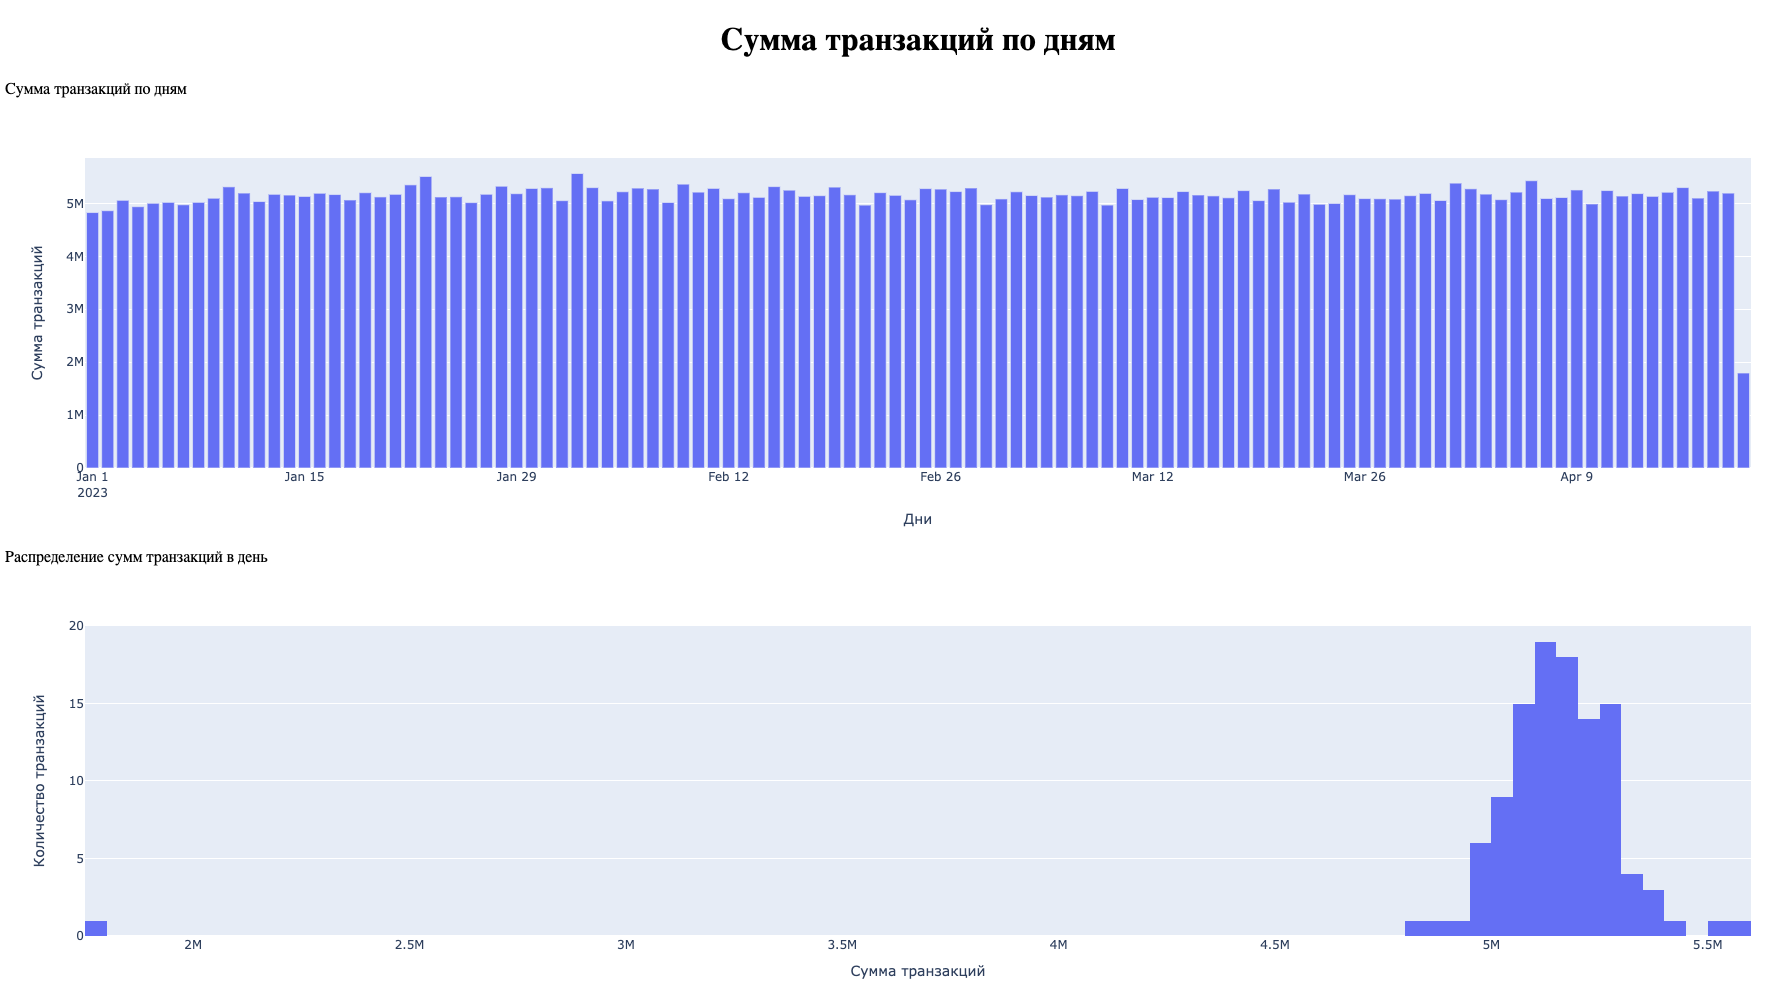

### Закрываем соединение

In [ ]:
connection.close()